In [70]:
import pandas as pd
import plotly.express as px
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from datetime import date

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.kernel_approximation import Nystroem

from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [5]:
# Utility function to create a submission csv.
def make_submission_file(df):
    current_submission_index = max([int(s.split("_")[2]) for s in listdir("submissions") if "csv" in s])
    df.to_csv(f"submissions/submission_pepe_{current_submission_index+1}_{date.today()}.csv", index=False)

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
def load_train_data():
    raw_train_data = pd.read_csv("train_data.csv")
    full_df = pd.merge(raw_train_data, pd.read_csv("train_label.csv"), on="id")
    full_df.fillna("No text", inplace=True)
    return full_df

In [4]:
full_df = load_train_data()

## Text classification

#### Let's start with cleaning the text.

In [7]:
def clean_text(text):

    found_url = re.findall(r"(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org)))", text)
    if found_url:
        text = text.replace(found_url[0], "")
        text = text.replace(found_url[0].split(".")[0], "")
    for w in text.split():
        if ".com" in w or "@" in w:
            text = text.replace(w, "")
            
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    # We remove all the single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # For now we remove all punctuation, but maybe for memes stuff like ! and ? important, we can test later.
    text = re.sub(r'[^\w\s]','', text)

    
    return text


In [8]:
def lemmatize_text(text):
    # Make a spacy pipe ffrom this later.
    doc = nlp(text)
    lemmas = [token.lemma_ if token.lemma_ not in ["-PRON-"] else token.text for token in doc]
    return " ".join(lemmas)
        

In [9]:
def add_relevant_columns(df, lemmatize=True):
    
    def add_lowercased_texts(df):
        df["lowercased_text"] = [t.lower() for t in df.Corrected_text]
        return df
    
    def clean_texts(df):
        df["cleaned_text"] = df.lowercased_text.apply(lambda x: clean_text(x))
        return df
    
    def lemmatize_texts(df):
        df["lemmatized_text"] = df.cleaned_text.apply(lambda x: lemmatize_text(x))
        return df
    
    if lemmatize:
        return lemmatize_texts(clean_texts(add_lowercased_texts(df)))
    else:
        return clean_texts(add_lowercased_texts(df))
    

In [10]:
prepared_train = add_relevant_columns(full_df, lemmatize=True)

In [11]:
prepared_train.sample(5)

,id,Corrected_text,Humour,lowercased_text,cleaned_text,lemmatized_text
4214,train_4215.jpg,waiting on the coffee to brew like... @coffee_...,funny,waiting on the coffee to brew like... @coffee_...,waiting on the coffee to brew like gene wilder...,wait on the coffee to brew like gene wilder be...
2746,train_2747.jpg,THE CATHEDRAL OP MISOGINS A meme-laden joke ad...,not_funny,the cathedral op misogins a meme-laden joke ad...,the cathedral op misogins memeladen joke adven...,the cathedral op misogin memeladen joke advent...
111,train_112.jpg,Me: I need to stop being lonely and talk to pe...,funny,me: i need to stop being lonely and talk to pe...,me need to stop being lonely and talk to peopl...,me need to stop be lonely and talk to people s...
3713,train_3714.jpg,The acadamy has given Leo an oscar... Leo is f...,funny,the acadamy has given leo an oscar... leo is f...,the acadamy has given leo an oscar leo is free,the acadamy have give leo an oscar leo be free
432,train_433.jpg,WHEN SOMEONE CALLS MY BEST FRIEND THEIR BEST F...,very_funny,when someone calls my best friend their best f...,when someone calls my best friend their best f...,when someone call my good friend their good fr...


### Featurizing text

In [12]:
le = LabelEncoder()

def add_label_encoding(df, encoder=le):
    categories = le.fit_transform(df.Humour)
    df["category"] = categories
    return df

def add_string_labels(df, encoder=le):
    labels = le.inverse_transform(df.category)
    df["Humour"] = labels
    return df

In [13]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2), max_features=3000, max_df=0.6, stop_words=None, 
                            strip_accents=None, analyzer="word")
def create_tfidf_features(df, tfidf_instance, text_column="lemmatized_text"):
    features = tfidf_instance.fit_transform(df[text_column]).toarray()
    return features

In [14]:
train_features = create_tfidf_features(prepared_train, tfidf)

In [15]:
prepared_train = add_label_encoding(prepared_train)

## Training classifiers

In [16]:
# Create the train data split to make our own test set.
X_train_own, X_test_own, y_train_own, y_test_own = train_test_split(prepared_train, prepared_train["category"], test_size=0.2, random_state=22)

In [113]:
# This is training on the whole set because we tesrt on holdout or using pipeline.
X_train = train_features
y_train = prepared_train["category"]
def fit_classifier(classifier_instance):
    classifier_instance.fit(X_train, y_train)
    return "Classifier is fitted!"

In [114]:
classifier_SVC = LinearSVC(class_weight="balanced")
classifier_RF = RandomForestClassifier(class_weight="balanced", n_estimators=200, n_jobs=-1)

In [115]:
fit_classifier(classifier_RF)

'Classifier is fitted!'

In [119]:
# y_pred = classifier_RF.predict(X_test_own)

In [ ]:
print(confusion_matrix(y_test_own,y_pred))
print(classification_report(y_test_own,y_pred))
print(accuracy_score(y_test_own, y_pred))

## Pipeline approach (with GridSearch)

In [56]:
from sklearn.pipeline import Pipeline

# With this pipeline, we can easily swap between different models and architectures and plug in different
# text pre-processing steps.

text_clf = Pipeline([
#     ('tfidf', TfidfVectorizer(min_df=4, ngram_range=(1, 3), max_features=5000, max_df=0.4, stop_words='english', 
#                             strip_accents="ascii", analyzer="char_wb", use_idf=True)),
#     ('countvectorizer', CountVectorizer()),
    ('tfidf', TfidfVectorizer()),
#     ("kernel_approx", Nystroem(gamma=.2,
#                                 random_state=1,
#                                 n_components=500)),
#     ('clf', RandomForestClassifier(class_weight="balanced", min_samples_split=3, n_estimators=500)),
    ('clf', LinearSVC(C=0.01, class_weight="balanced", tol=0.0001))
#     ('clf', SVC())
#     ('clf', LogisticRegression())
])

In [57]:
text_clf.fit(X_train_own.lemmatized_text, y_train_own)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=0.01, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
        

In [122]:
y_pred_pipeline = text_clf.predict(X_test_own.lemmatized_text)

In [123]:
np.mean(y_pred_pipeline == y_test_own)

0.3357142857142857

In [124]:
print(confusion_matrix(y_test_own,y_pred_pipeline))
print(classification_report(y_test_own,y_pred_pipeline))
print(accuracy_score(y_test_own, y_pred_pipeline))

[[214   6  26 132]
 [ 49   1  14  44]
 [150   1  21  80]
 [203   6  33 140]]
              precision    recall  f1-score   support

           0       0.35      0.57      0.43       378
           1       0.07      0.01      0.02       108
           2       0.22      0.08      0.12       252
           3       0.35      0.37      0.36       382

    accuracy                           0.34      1120
   macro avg       0.25      0.26      0.23      1120
weighted avg       0.29      0.34      0.30      1120

0.3357142857142857


In [30]:
##### GRIDSEARCH ######

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__min_df': [3,4,5,10,15,20],
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__max_df': (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
    'tfidf__stop_words': ["english", None],
    'tfidf__strip_accents': [None, 'ascii'],
    'tfidf__analyzer': ["word", "char", "char_wb"],
#     'clf__n_estimators': [100, 200, 300, 400, 500, 1000],
#     'clf__min_samples_split': [2, 3, 4, 5],
#     'clf__class_weight': ["balanced"],
#     'clf__tol': [0.0001, 0.001, 0.01, 0.00001],
#     'clf__C': [0.01, 0.1, 1, 2, 5],
#     'clf__kernel': ["poly", "rbf", "sigmoid"],
#     'clf__break_ties': [True]
}

In [59]:
# gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=1)
rs_clf = RandomizedSearchCV(text_clf, parameters, n_iter=700, n_jobs=-1, verbose=1, cv=2)

In [60]:
# gs_clf.fit(X_train_own.lemmatized_text, y_train_own)
rs_clf.fit(X_train_own.lemmatized_text, y_train_own)

Fitting 2 folds for each of 700 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  2.1min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                       

In [61]:
# random_results = []

In [62]:
# gs_clf.best_params_
rs_clf.best_params_

{'tfidf__analyzer': 'word',
 'tfidf__max_df': 0.2,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__use_idf': True}

In [63]:
random_results.append([rs_clf.best_params_, rs_clf.best_score_])

In [64]:
rs_clf.best_score_

0.35022321428571423

In [66]:
y_pred_pipeline = rs_clf.predict(X_test_own.lemmatized_text)

In [67]:
print(confusion_matrix(y_test_own,y_pred_pipeline))
print(classification_report(y_test_own,y_pred_pipeline))
print(accuracy_score(y_test_own, y_pred_pipeline))

[[243   5  16 114]
 [ 65   2  11  30]
 [161   6  15  70]
 [238   5  21 118]]
              precision    recall  f1-score   support

           0       0.34      0.64      0.45       378
           1       0.11      0.02      0.03       108
           2       0.24      0.06      0.10       252
           3       0.36      0.31      0.33       382

    accuracy                           0.34      1120
   macro avg       0.26      0.26      0.23      1120
weighted avg       0.30      0.34      0.29      1120

0.3375


In [90]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("fig.svg")
    plt.show()
    

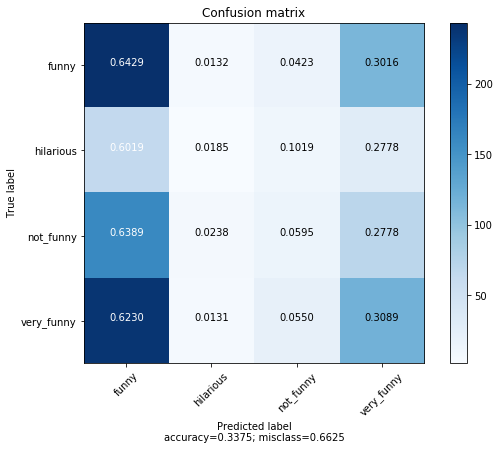

In [91]:
cm = plot_confusion_matrix(confusion_matrix(y_test_own,y_pred_pipeline), ["funny", "hilarious", "not_funny", "very_funny"])

## Predicting on real test set

In [42]:
def load_real_test_set(lemmatize=True):
    test_data = pd.read_csv("test_data.csv")
    test_data.fillna("No text", inplace=True)
    test_texts_lowercase = [t.lower() for t in test_data.Corrected_text]
    test_data["lowercased_text"] = test_texts_lowercase
    test_data["cleaned_text"] = test_data.lowercased_text.apply(lambda x: clean_text(x))
    if lemmatize:
        test_data["lemmatized_text"] = test_data.cleaned_text.apply(lambda x: lemmatize_text(x))
    else:
        pass
    return test_data
    

In [43]:
def get_test_set_features(tfidf_instance, test_set, text_column="lemmatized_text"):
    return tfidf_instance.transform(test_set[text_column])

In [44]:
real_test_set = load_real_test_set()

In [376]:
real_test_set_features = get_test_set_features(tfidf, real_test_set)

In [96]:
test_pred = rs_clf.predict(real_test_set.lemmatized_text)

In [97]:
real_test_set["category"] = test_pred

In [98]:
real_test_set = add_string_labels(real_test_set)

In [99]:
real_test_set.head()

,id,Corrected_text,lowercased_text,cleaned_text,lemmatized_text,category,Humour
0,test_1.jpg,OK LAST PODCASTERS THE GAME IS...POST YOUR FAV...,ok last podcasters the game is...post your fav...,ok last podcasters the game ispost your favori...,ok last podcaster the game ispost your favorit...,0,funny
1,test_2.jpg,THERE ARE LIMITS self hating Joke here,there are limits self hating joke here,there are limits self hating joke here,there be limit self hat joke here,0,funny
2,test_3.jpg,AFRICAN LION LYIN' AFRICAN It's not racist it...,african lion lyin' african it's not racist it...,african lion lyin african its not racist its t...,african lion lyin african its not racist its t...,0,funny
3,test_4.jpg,WHAAAAAAAAT IWASNT LISTENING,whaaaaaaaat iwasnt listening,whaaaaaaaat iwasnt listening,whaaaaaaaat iwasnt listening,3,very_funny
4,test_5.jpg,HOW DO WE DESTROY THE PATRIARCHY? IT'S SIMPLE....,how do we destroy the patriarchy? it's simple....,how do we destroy the patriarchy its simple we...,how do we destroy the patriarchy its simple we...,0,funny


In [100]:
def make_predictions_df(test_data_with_pred):
    df = test_data_with_pred[["id", "Humour"]]
    return df

In [101]:
submission_df = make_predictions_df(real_test_set)

In [102]:
submission_df.head()

,id,Humour
0,test_1.jpg,funny
1,test_2.jpg,funny
2,test_3.jpg,funny
3,test_4.jpg,very_funny
4,test_5.jpg,funny


In [531]:
make_submission_file(make_predictions_df(dd))